In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'C:\\Users\\KRISHA\\OneDrive - National Institute of Technology Karnataka, Surathkal\\Documents\\ASAN FREELANCING\\General\\dataset.tsv'
df = pd.read_csv(file_path, sep='\t')

# Extract Hinglish and English queries
df = df[['cs_query', 'en_query']]

# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['cs_query'].tolist(), df['en_query'].tolist(), test_size=0.2, random_state=42
)

# Add <start> and <end> tokens to English labels before fitting the tokenizer
train_labels = ["<start> " + label + " <end>" for label in train_labels]
test_labels = ["<start> " + label + " <end>" for label in test_labels]

# Initialize tokenizers
hinglish_tokenizer = Tokenizer()
english_tokenizer = Tokenizer(filters='')  # Disable filtering to include special tokens

# Fit the tokenizers
hinglish_tokenizer.fit_on_texts(train_texts)
english_tokenizer.fit_on_texts(train_labels)  # Fit on modified labels with <start> and <end>

# Verify <start> and <end> tokens are present
print('<start>' in english_tokenizer.word_index)  # Should now print True
print('<end>' in english_tokenizer.word_index)    # Should now print True

# Convert text to sequences
train_input_seq = hinglish_tokenizer.texts_to_sequences(train_texts)
train_output_seq = english_tokenizer.texts_to_sequences(train_labels)

test_input_seq = hinglish_tokenizer.texts_to_sequences(test_texts)
test_output_seq = english_tokenizer.texts_to_sequences(test_labels)

# Pad sequences
max_len_input = max(len(seq) for seq in train_input_seq)
max_len_output = max(len(seq) for seq in train_output_seq)

train_input_seq = pad_sequences(train_input_seq, maxlen=max_len_input, padding='post')
train_output_seq = pad_sequences(train_output_seq, maxlen=max_len_output, padding='post')

test_input_seq = pad_sequences(test_input_seq, maxlen=max_len_input, padding='post')
test_output_seq = pad_sequences(test_output_seq, maxlen=max_len_output, padding='post')



True
True


In [3]:
print(test_texts)

['dopaher 3 baje mousam kaisa hoga ye samjhne me meri madad kare', 'kal 6 bajhe utne ke liye alarm set kare', 'kya is evening 5 pm ko baarish hogi', 'Friday 5 baje ke liye alarm create kare', 'Jab hum Houston me ho toh mai kids ke sath kya kar sakta hu', 'Mai Anthony Ford ko ek video message bhejna chahta hu .', 'naya reminder set kijiye', 'jab mai is weights se done hojaungi', 'aaj humindity ka level kya hai ?', 'Subah ke alarm ko cancel kare', 'Yaha se the Dali Museum kitni door hai', 'kya baarish hone wali hai', 'Kya next week mere aas paas koi event hone wali he', 'kya aap meri sister ke kutte ko walk par lejaane wale alerts se chutkara paa sakte hai ?', 'Thursday par vet ke liye mere reminder ko cancel kardo', 'kya aj barish hone wali hai', 'Kya aaj baarish hogi ?', 'aj traffic kaisa dikh raha hai', 'carly ko message karo ki the roads are gettin slick . she might want to stay home today', 'is song ko rok den', 'mujhe sandy , tj aur tima ke liye flight tickets book karne ke liye ya

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model

# Hyperparameters
embedding_dim = 256
lstm_units = 512

# Encoder
encoder_inputs = Input(shape=(max_len_input,))
encoder_embedding = Embedding(input_dim=len(hinglish_tokenizer.word_index) + 1, output_dim=embedding_dim)(encoder_inputs)
encoder_lstm, state_h, state_c = LSTM(lstm_units, return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_len_output,))
decoder_embedding = Embedding(input_dim=len(english_tokenizer.word_index) + 1, output_dim=embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(len(english_tokenizer.word_index) + 1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 31)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 36)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 31, 256)           │         671,744 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 36, 256)           │         531,968 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ [(None, 512), (None,      │       1,574,912 │ embedding[0][0]            │
│                               │ 512), (None, 512)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ [(None, 36, 512), (None,  │       1,574,912 │ embedding_1[0][0],         │
│                               │ 512), (None, 512)]        │                 │ lstm[0][1], lstm[0][2]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 36, 2078)          │       1,066,014 │ lstm_1[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 5,419,550 (20.67 MB)

 Trainable params: 5,419,550 (20.67 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Prepare decoder targets
train_output_seq_shifted = np.expand_dims(train_output_seq, axis=-1)

# Train the model
history = model.fit(
    [train_input_seq, train_output_seq], train_output_seq_shifted,
    batch_size=64,
    epochs=10,
    validation_split=0.2
)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 32s 960ms/step - accuracy: 0.6466 - loss: 3.8332 - val_accuracy: 0.7710 - val_loss: 1.4024
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 954ms/step - accuracy: 0.7696 - loss: 1.3856 - val_accuracy: 0.7834 - val_loss: 1.2821
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 925ms/step - accuracy: 0.7839 - loss: 1.2501 - val_accuracy: 0.8018 - val_loss: 1.1958
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 939ms/step - accuracy: 0.8063 - loss: 1.1621 - val_accuracy: 0.8255 - val_loss: 1.0859
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 951ms/step - accuracy: 0.8287 - loss: 1.0174 - val_accuracy: 0.8463 - val_loss: 0.9832
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 887ms/step - accuracy: 0.8471 - loss: 0.9220 - val_accuracy: 0.8690 - val_loss: 0.8786
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 904ms/step - accuracy: 0.8695 - loss: 0.8187 - val_accuracy: 0.8902 - val_loss: 0.7814
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 26s 883ms/step - accuracy: 0.8924 - loss: 0.6986 - val_accu

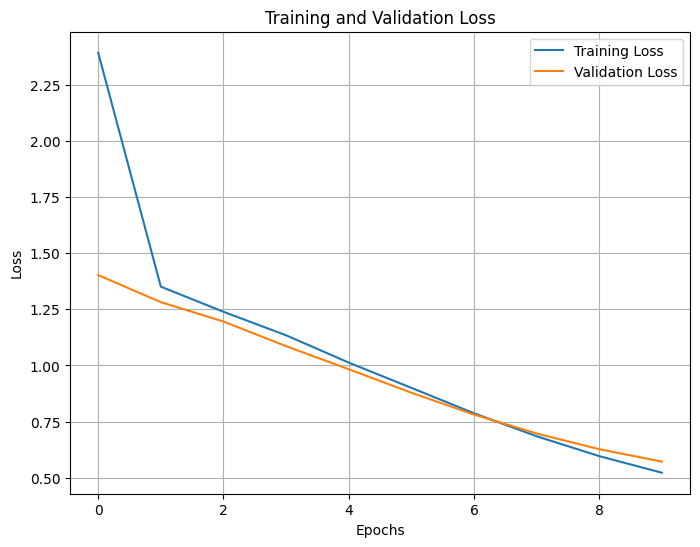

In [6]:


# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

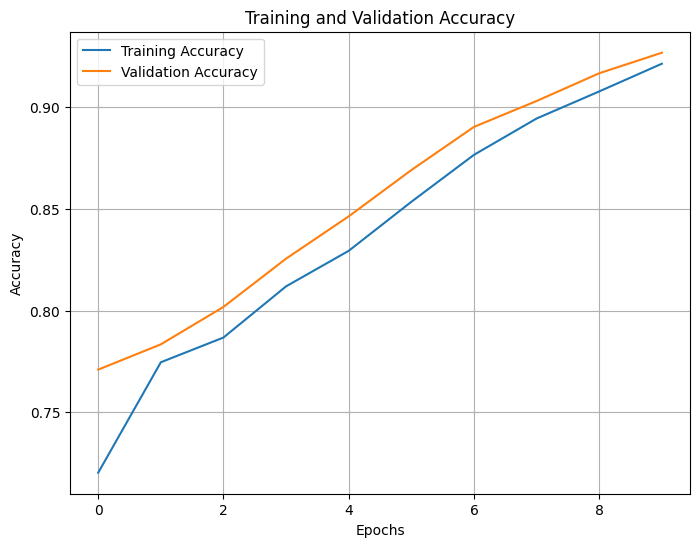

In [7]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [16]:
# Extract accuracy metrics
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Print final accuracy
print(f"Final Training Accuracy: {train_accuracy[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")

Final Training Accuracy: 0.9212
Final Validation Accuracy: 0.9266


In [8]:
# Save the model
model.save("hinglish_to_english_model.h5")

# Load the model
model = tf.keras.models.load_model("hinglish_to_english_model.h5")


In [9]:
# Define the encoder model
encoder_model = Model(encoder_inputs, encoder_states)

# Define the decoder model
decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_embedding, initial_state=decoder_states_inputs
)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

# Translation function
def translate_hinglish_to_english(hinglish_sentence):
    sequence = hinglish_tokenizer.texts_to_sequences([hinglish_sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_len_input, padding='post')

    # Encode the input sequence
    states_value = encoder_model.predict(padded_sequence)

    # Initialize the decoder with the <start> token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = english_tokenizer.word_index['<start>']

    translated_sentence = []
    stop_condition = False
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = english_tokenizer.index_word.get(sampled_token_index, '')

        if sampled_word == '<end>' or len(translated_sentence) > max_len_output:
            stop_condition = True
        else:
            translated_sentence.append(sampled_word)

        # Update the target sequence with the sampled token
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update the states
        states_value = [h, c]

    return ' '.join(translated_sentence)

# # Test the model
# test_sentence = "tum kya kar rahe ho?"
# translation = translate_hinglish_to_english(test_sentence)
# print(f"Hinglish: {test_sentence}\nEnglish: {translation}")


In [15]:
model_input = test_texts[3]
output = test_labels[3]
print(f"Input in Hinglish: {model_input},\nOutput in English: {output}")

Input in Hinglish: Friday 5 baje ke liye alarm create kare,
Output in English: <start> Create an alarm for Fridays at 5 pm <end>
